In [86]:
from numpy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Input parameters

In [2]:
p_mixture = np.array([0.2, 0.3, 0.5])
gaussian_params = (np.array([-1., 4., 9.]), np.array([2., 3., 1.]), np.array([0.2, 0.3, 0.5]))

p_cum = np.cumsum(p_mixture)


##  EM calculation code

In [109]:
# this is a formatting function for print
pretty = lambda arr: np.array2string(arr, precision=2, suppress_small=True)

# main function
def gaussian_em_procedure(data, initial_g_params, tol, verbose=True):
    # data: the samples (as 1-D vector) length n
    # initial_g_params: a tuple of three parameters, the initial mu, initial sigma_sq, and initial mixture prob's
    # tol: min change of any parameter between iterations to continue
    # verbose: print intermediate results
    cond = True
    current_g_params = initial_g_params
    current_w = None
    
    lls = []
    while cond:
        prev_g_params = current_g_params
        prev_w = current_w
        current_w, likelihood = e_step(data, current_g_params)
        lls.append(likelihood)
        current_g_params = m_step(data, current_w, verbose)
        if prev_w is not None:
            max_diff = max(
                [abs(prev-current).max() for prev, current in zip(prev_g_params, current_g_params)]+ 
                [abs(prev_w-current_w).max()])
            cond = max_diff > tol
            #print("max diff: {}".format(max_diff))
    mu, sigma_sq, mixture = current_g_params        
    return (
        pd.DataFrame(np.hstack([data[:,np.newaxis], current_w])), 
        pd.DataFrame({"mu":mu.squeeze(), "sigma_sq": sigma_sq.squeeze(), "mixture": mixture}), 
        np.log(np.array(lls))
    )


# implements the calculation of the M-step
def m_step(data, current_w, verbose):
    global iteration
    mixture = current_w.sum(axis=0)/data.shape[0]
    mu = (data[:, np.newaxis]*current_w).sum(axis=0,keepdims=True) / current_w.sum(axis=0)
    sigma_sq =  ((data[:, np.newaxis] - mu)**2 * current_w).sum(axis=0) / current_w.sum(axis=0)
    iteration += 1
    if verbose:
        print("iteration: {}, mu {}; sigma {}; mixture {}".format(iteration, pretty(mu), pretty(sigma_sq), pretty(mixture)))
    return mu, sigma_sq, mixture


# implements the calculation of the E-step
# and also outputs the total likelihood
def e_step(data, current_g_params):
    mu, sigma_sq, mixture = current_g_params
    # group likelihood before exponentiation
    group_likelihood = -(data[:,np.newaxis] - np.tile(mu,(data.shape[0],1)))**2 /(2 * sigma_sq)
    # exponentiate
    group_likelihood = np.exp(group_likelihood)
    # normalize by sqrt(sigma_sq)
    group_likelihood = group_likelihood/ np.sqrt(sigma_sq)
    # multiply by mixture
    group_likelihood = group_likelihood * mixture
    total_likelihood = group_likelihood.sum()
    group_likelihood = group_likelihood/ group_likelihood.sum(axis=1, keepdims=True)
    return group_likelihood, total_likelihood



## Run 1
### 200 samples, start with true (theoretical) parameters
### Note: the realized mixture is different thatn the theoretical mixture

In [96]:
global iteration
iteration = 0
n_samples = 200
y =  np.digitize(random.rand(n_samples),p_cum)
z = random.randn(n_samples)*np.sqrt(gaussian_params[1][y])+gaussian_params[0][y]

In [97]:
initial_g_params = (np.array([-1., 4., 9.]), np.array([2., 3., 1.]), np.array([0.2, 0.3, 0.5]))
res = gaussian_em_procedure(z, initial_g_params, 0.0001)

iteration: 1, mu [[-0.8   4.07  9.06]]; sigma [1.62 2.95 0.93]; mixture [0.16 0.27 0.56]
iteration: 2, mu [[-0.81  4.1   9.07]]; sigma [1.56 2.87 0.91]; mixture [0.16 0.28 0.56]
iteration: 3, mu [[-0.81  4.11  9.08]]; sigma [1.54 2.83 0.9 ]; mixture [0.16 0.28 0.56]
iteration: 4, mu [[-0.81  4.12  9.08]]; sigma [1.54 2.81 0.9 ]; mixture [0.16 0.27 0.56]
iteration: 5, mu [[-0.81  4.12  9.08]]; sigma [1.54 2.79 0.9 ]; mixture [0.16 0.27 0.56]
iteration: 6, mu [[-0.8   4.12  9.08]]; sigma [1.54 2.78 0.9 ]; mixture [0.16 0.27 0.56]
iteration: 7, mu [[-0.8   4.12  9.08]]; sigma [1.55 2.77 0.9 ]; mixture [0.17 0.27 0.56]
iteration: 8, mu [[-0.8   4.13  9.08]]; sigma [1.55 2.77 0.9 ]; mixture [0.17 0.27 0.56]
iteration: 9, mu [[-0.8   4.13  9.08]]; sigma [1.55 2.76 0.9 ]; mixture [0.17 0.27 0.56]
iteration: 10, mu [[-0.8   4.13  9.08]]; sigma [1.55 2.75 0.9 ]; mixture [0.17 0.27 0.56]
iteration: 11, mu [[-0.79  4.13  9.08]]; sigma [1.56 2.74 0.9 ]; mixture [0.17 0.27 0.56]
iteration: 12, mu [

In [101]:
res[0].columns=['data','P_group1','P_group2','P_group3']
display(res[0].applymap(lambda x: round(x,3)))


,data,P_group1,P_group2,P_group3
0,8.019,0.000,0.030,0.970
1,6.347,0.000,0.876,0.124
2,7.823,0.000,0.050,0.950
3,6.687,0.000,0.664,0.336
4,2.852,0.016,0.984,0.000
5,3.924,0.001,0.999,0.000
6,9.435,0.000,0.002,0.998
7,9.900,0.000,0.001,0.999
8,8.281,0.000,0.016,0.984
9,9.997,0.000,0.001,0.999


,0,1,2
mu,-0.780,4.136,9.075
sigma_sq,1.577,2.679,0.899
mixture,0.167,0.271,0.562


In [99]:
display(res[1].T.applymap(lambda x: round(x,3)))

,0,1,2
mu,-0.780,4.136,9.075
sigma_sq,1.577,2.679,0.899
mixture,0.167,0.271,0.562


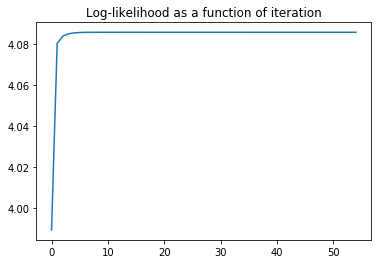

In [100]:
plt.plot(res[2])
plt.title("Log-likelihood as a function of iteration");

## Run 2
### 20 samples, start with true (theoretical) parameters


In [104]:
global iteration
iteration = 0
n_samples = 20
y =  np.digitize(random.rand(n_samples),p_cum)
z = random.randn(n_samples)*np.sqrt(gaussian_params[1][y])+gaussian_params[0][y]

In [105]:
initial_g_params = (np.array([-1., 4., 9.]), np.array([2., 3., 1.]), np.array([0.2, 0.3, 0.5]))
res = gaussian_em_procedure(z, initial_g_params, 0.0001)

iteration: 1, mu [[-1.72  3.56  9.16]]; sigma [3.75 2.3  0.75]; mixture [0.18 0.27 0.55]
iteration: 2, mu [[-1.83  3.41  9.16]]; sigma [3.62 2.03 0.75]; mixture [0.17 0.28 0.55]
iteration: 3, mu [[-1.94  3.38  9.16]]; sigma [3.32 2.   0.75]; mixture [0.17 0.28 0.55]
iteration: 4, mu [[-2.04  3.35  9.16]]; sigma [3.01 2.03 0.75]; mixture [0.17 0.29 0.55]
iteration: 5, mu [[-2.14  3.32  9.16]]; sigma [2.71 2.06 0.75]; mixture [0.16 0.29 0.55]
iteration: 6, mu [[-2.24  3.29  9.16]]; sigma [2.42 2.1  0.75]; mixture [0.16 0.29 0.55]
iteration: 7, mu [[-2.33  3.26  9.16]]; sigma [2.17 2.15 0.75]; mixture [0.15 0.3  0.55]
iteration: 8, mu [[-2.39  3.24  9.16]]; sigma [1.97 2.19 0.75]; mixture [0.15 0.3  0.55]
iteration: 9, mu [[-2.44  3.22  9.16]]; sigma [1.85 2.23 0.75]; mixture [0.15 0.3  0.55]
iteration: 10, mu [[-2.47  3.2   9.16]]; sigma [1.77 2.28 0.75]; mixture [0.15 0.3  0.55]
iteration: 11, mu [[-2.49  3.19  9.16]]; sigma [1.73 2.31 0.75]; mixture [0.14 0.31 0.55]
iteration: 12, mu [

In [106]:
res[0].columns=['data','P_group1','P_group2','P_group3']
display(res[0].applymap(lambda x: round(x,3)))


,data,P_group1,P_group2,P_group3
0,1.630,0.004,0.996,0.000
1,8.877,0.000,0.000,1.000
2,8.883,0.000,0.000,1.000
3,9.477,0.000,0.000,1.000
4,8.389,0.000,0.002,0.998
5,-3.792,1.000,0.000,0.000
6,8.391,0.000,0.002,0.998
7,-0.694,0.795,0.205,0.000
8,4.600,0.000,1.000,0.000
9,1.361,0.010,0.990,0.000


In [107]:
display(res[1].T.applymap(lambda x: round(x,3)))

,0,1,2
mu,-2.545,3.148,9.161
sigma_sq,1.633,2.467,0.746
mixture,0.140,0.310,0.550


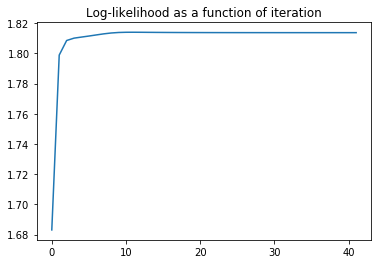

In [108]:
plt.plot(res[2])
plt.title("Log-likelihood as a function of iteration");

In [96]:
global iteration
iteration = 0
n_samples = 200
y =  np.digitize(random.rand(n_samples),p_cum)
z = random.randn(n_samples)*np.sqrt(gaussian_params[1][y])+gaussian_params[0][y]

In [112]:
res_batch = []
for i in range(10):
    #initial_g_params = (np.array([-1., 4., 9.]), np.array([2., 3., 1.]), np.array([0.2, 0.3, 0.5]))
    initial_g_params = [random.rand(3)*10-1, random.rand(3)*3+1, random.rand(3)]
    initial_g_params[2] = initial_g_params[2]/initial_g_params[2].sum()
    res_batch.append(gaussian_em_procedure(z, initial_g_params, 0.0001, verbose=False))

In [116]:
for r in res_batch:
    display(r[1].sort_values('mu'))

,mu,sigma_sq,mixture
2,1.559055,10.335508,0.461678
1,8.849992,0.245661,0.446088
0,10.682010,0.372386,0.092234


,mu,sigma_sq,mixture
2,-2.545011,1.632889,0.140389
0,3.148388,2.466821,0.310102
1,9.160658,0.745968,0.549510


,mu,sigma_sq,mixture
2,-2.545002,1.632902,0.140389
0,3.148395,2.466796,0.310101
1,9.160658,0.745968,0.549510


,mu,sigma_sq,mixture
2,-2.545024,1.632871,0.140388
1,3.148378,2.466857,0.310103
0,9.160658,0.745968,0.549510


,mu,sigma_sq,mixture
2,-2.545016,1.632881,0.140388
1,3.148384,2.466836,0.310102
0,9.160658,0.745968,0.549510


,mu,sigma_sq,mixture
0,-2.545008,1.632894,0.140389
1,3.148391,2.466811,0.310101
2,9.160658,0.745968,0.549510


,mu,sigma_sq,mixture
2,1.559109,10.335845,0.461682
0,8.850344,0.245956,0.446255
1,10.683688,0.371239,0.092063


,mu,sigma_sq,mixture
0,1.559054,10.335501,0.461678
2,8.849986,0.245655,0.446085
1,10.681978,0.372408,0.092237


,mu,sigma_sq,mixture
1,1.559054,10.335497,0.461678
2,8.849982,0.245652,0.446083
0,10.681958,0.372422,0.092239


,mu,sigma_sq,mixture
2,-0.313739,6.563804,0.282694
0,4.211710,0.626681,0.167545
1,9.160233,0.745891,0.549761
